# Generative Adversarial Networks in Keras

In [3]:
%matplotlib inline
from importlib import reload
import utils2; reload(utils2)
from utils2 import *

from tqdm import tqdm

## The original GAN!

See [this paper](https://arxiv.org/abs/1406.2661) for details of the approach we'll try first for our first GAN. We'll see if we can generate hand-drawn numbers based on MNIST, so let's load that dataset first.

We'll be refering to the discriminator as 'D' and the generator as 'G'.

In [10]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [11]:
n = len(X_train); n

60000

In [13]:
X_train = X_train.reshape(len(X_train), -1).astype(np.float32)
X_test = X_test.reshape(len(X_test), -1).astype(np.float32)

In [14]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [15]:
X_train /= 255.; X_test /= 255.

## Train

This is just a helper to plot a bunch of generated images.

In [33]:
def plot_gen(G, n_ex=16):
    plot_multi(G.predict(noise(n_ex)).reshape(n_ex, 28, 28), cmap='gray')

Create some random data for the generator.

In [18]:
def noise(bs): return np.random.rand(bs,100)

Create a batch of some real and some generated data, with appropriate labels, for the discriminator.

In [20]:
def data_D(sz, G):
    real_img = X_train[np.random.randint(0,n,size=sz)]
    X = np.concatenate((real_img, G.predict(noise(sz))))
    return X, [0]*sz+[1]*sz  # data, label

In [21]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: l.trainable = val

Train a few epochs, and return the losses for D and G. In each epoch we:

1. Train D on one batch from data_D()
2. Train G to create images that the discriminator predicts as real.

In [22]:
def train(D, G, m, epochs=5000, bs=128):
    dl,gl=[],[]
    for e in tqdm(range(epochs)):
        # train Discriminator
        X,y = data_D(bs//2, G)
        dl.append(D.train_on_batch(X,y))
        
        make_trainable(D, False)
        
        # train Generator thru the whole model
        gl.append(m.train_on_batch(noise(bs), np.zeros([bs])))  
        
        make_trainable(D, True)
        
    return dl, gl

## MLP GAN

We'll keep thinks simple by making D & G plain ole' MLPs.

In [23]:
MLP_G = Sequential([
    Dense(200, input_shape=(100,), activation='relu'),
    Dense(400, activation='relu'),
    Dense(784, activation='sigmoid')
])

In [24]:
MLP_D = Sequential([
    Dense(300, input_shape=(784,), activation='relu'),
    Dense(300, activation='relu'),
    Dense(1, activation='sigmoid')
])
MLP_D.compile(Adam(1e-4), 'binary_crossentropy')

In [25]:
MLP_m = Sequential([MLP_G, MLP_D])
MLP_m.compile(Adam(1e-4), 'binary_crossentropy')

In [27]:
dl,gl = train(MLP_D, MLP_G, MLP_m, 8000)

  0%|          | 0/8000 [00:00<?, ?it/s]/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 8000/8000 [01:43<00:00, 77.30it/s]


The loss plots for most GANs are nearly impossible to interpret - which is one of the things that make them hard to train.

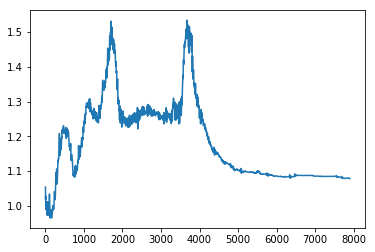

In [28]:
plt.plot(dl[100:])

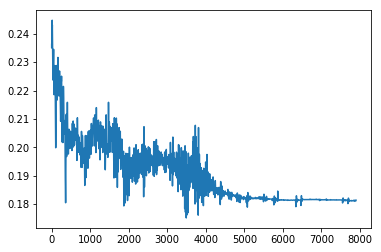

In [29]:
plt.plot(gl[100:])

This is what's known in the literature as "mode collapse".

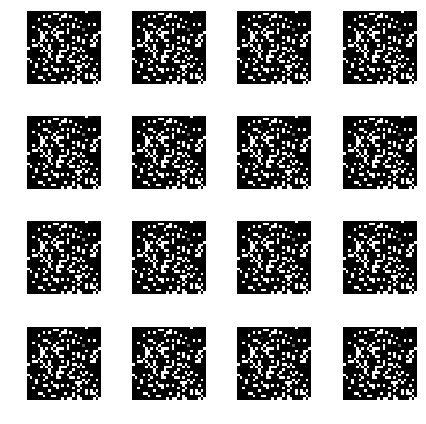

In [34]:
plot_gen(MLP_G)

OK, so that didn't work. Can we do better?...

## DCGAN

There's lots of ideas out there to make GANs train better, since they are notoriously painful to get working. The [paper introducing DCGANs](https://arxiv.org/abs/1511.06434) is the main basis for our next section. Add see https://github.com/soumith/ganhacks for many tips!

Because we're using a CNN from now on, we'll reshape our digits into proper images.

In [35]:
X_train = X_train.reshape(len(X_train), 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

Our generator uses a number of upsampling steps as suggested in the above papers. We use nearest neighbor upsampling rather than fractionally strided convolutions, as discussed in our style transfer notebook.

In [42]:
CNN_G = Sequential([
    Dense(512*7*7, input_dim=100, activation=LeakyReLU()),
    BatchNormalization(),
    Reshape((7 ,7 ,512)),
    UpSampling2D(),
    Conv2D(64, (3,3), padding='same', activation=LeakyReLU()),
    BatchNormalization(),
    UpSampling2D(),
    Conv2D(32, (3,3), padding='same', activation=LeakyReLU()),
    BatchNormalization(),
    Conv2D(1, (1,1), padding='same', activation='sigmoid')
])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


The discriminator uses a few downsampling steps through strided convolutions.

In [43]:
CNN_D = Sequential([
    Conv2D(256, (5, 5), strides=(2, 2), padding='same',
          input_shape=(28, 28, 1), activation=LeakyReLU()),
    Conv2D(512, (5, 5), strides=(2, 2), padding='same', activation=LeakyReLU()),
    Flatten(),
    Dense(256, activation=LeakyReLU()),
    Dense(1, activation='sigmoid')
])

CNN_D.compile(Adam(1e-3), "binary_crossentropy")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


We train D a "little bit" so it can at least tell a real image from random noise.

In [45]:
sz = n//200
x1 = np.concatenate([np.random.permutation(X_train)[:sz], CNN_G.predict(noise(sz))])
CNN_D.fit(x1, [0]*sz+[1]*sz, batch_size=128, epochs=1, verbose=2)

Epoch 1/1
 - 1s - loss: 0.0486


In [46]:
CNN_m = Sequential([CNN_G, CNN_D])
CNN_m.compile(Adam(1e-4), "binary_crossentropy")

In [47]:
K.set_value(CNN_D.optimizer.lr, 1e-3)
K.set_value(CNN_m.optimizer.lr, 1e-3)

Now we can train D & G iteratively.

In [49]:
dl, gl = train(CNN_D, CNN_G, CNN_m, 2500)

  0%|          | 0/2500 [00:00<?, ?it/s]/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 2500/2500 [13:19<00:00,  3.13it/s]


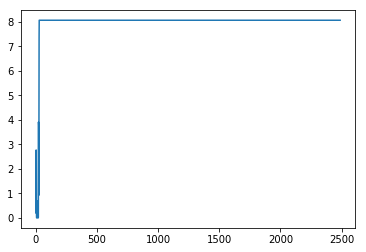

In [50]:
plt.plot(dl[10:])

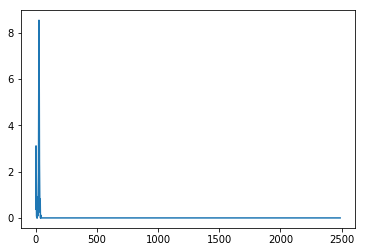

In [51]:
plt.plot(gl[10:])

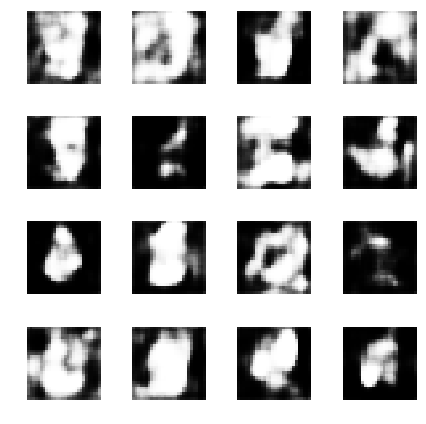

In [52]:
plot_gen(CNN_G)

## End